In [1]:
from pathlib import Path
from fastai import *
from fastai.vision import *
import torch
import os
!pip install efficientnet-pytorch
from efficientnet_pytorch import EfficientNet

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-cp36-none-any.whl size=16031 sha256=d7b0725ea1dfdd0718ed529e7d8211708a9c801a211acb4a26dbef887569c4be
  Stored in directory: /root/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
Successfully built efficientnet-pytorch


In [2]:
import cv2,os
import pandas as pd
import numpy as py
%cd drive/My\ Drive
import warnings
warnings.filterwarnings("ignore")

/content/drive/My Drive


In [3]:
train_csv_path = "train_label_aug_.csv"
test_folder = "test_image_ori/test"
train_folder = "train_image/train_image"
train_csv_01_path = "train_label_01.csv"
train_folder01 = "train_image_01/train_image"
sz = 512  #512
bs = 16

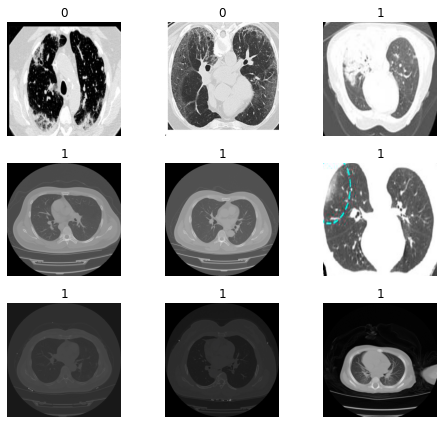

In [4]:
data_folder = Path(train_folder)
train_df = pd.read_csv(train_csv_path)

data = (ImageList.from_df(train_df, path=Path('.'),suffix='.png', folder=train_folder)
    .split_by_rand_pct(0.01)
    .label_from_df()
    .databunch(path='.', bs=bs))
stats=data.batch_stats()
data.normalize(stats)

# abandoned, now we directly apply efficientNet instead of doing classification twice.
train_df01 = pd.read_csv(train_csv_01_path)
data01 = (ImageList.from_df(train_df01, path=Path('.'),suffix='.png', folder=train_folder01)
    .split_by_rand_pct(0.01)
    .label_from_df()
    .databunch(path='.', bs=bs))
stats=data01.batch_stats()
data01.normalize(stats)
data01.show_batch(rows=3, figsize=(7,6))

In [5]:
# Model Build
model = EfficientNet.from_pretrained('efficientnet-b1')
model._fc = nn.Linear(1280, data.c)
# learn = Learner(data, model, metrics=[accuracy]) #modify
learn = Learner(data, model, metrics=[accuracy]) 

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b1-f1951068.pth



Loaded pretrained weights for efficientnet-b1


learn.lr_find()

learn.recorder.plot()

learn.fit_one_cycle(4, max_lr=slice(3e-03),moms=(0.95, 0.85)) #4 epochs ,  moms=(0.95, 0.85), pct_start=0.3

learn.recorder.plot_lr(show_moms=True)

learn.save('resnet34-1')

learn.unfreeze()

learn.lr_find()

learn.recorder.plot() #左下图

learn.load('resnet34-1')

learn.fit_one_cycle(2, max_lr=slice(3e-5,6e-5), div_factor=25.0, moms=(0.95, 0.85), pct_start=0.3)

learn.recorder.plot_lr(show_moms=True)


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.09E-03
Min loss divided by 10: 1.10E-03


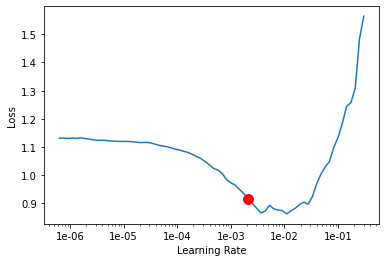

In [6]:
# Find best learning rate, which have the best grad in figure 
# print(model)
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,time
0,0.282171,1.074018,0.867470,15:51
1,0.204314,0.171922,0.939759,04:15
2,0.062813,0.038738,0.975904,04:15
3,0.024163,0.042324,0.975904,04:15


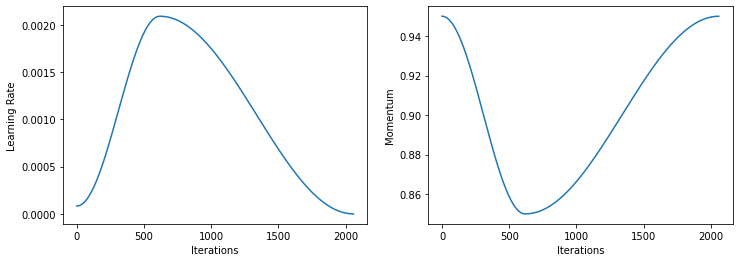

In [6]:
# fit the model 4 epochs.
learn.fit_one_cycle(4, max_lr=slice(2.09E-03),moms=(0.95, 0.85)) #4 epochs , moms=(0.95, 0.85), pct_start=0.3
learn.recorder.plot_lr(show_moms=True)

In [ ]:
learn.save('efficient-2')

In [7]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-06
Min loss divided by 10: 1.10E-07


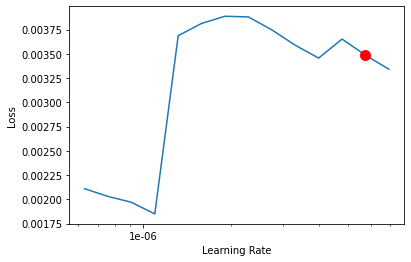

In [ ]:
# Try to train the model by unfreezing all layers. 
learn.lr_find()
learn.recorder.plot(suggestion=True) #左下图

In [ ]:
# In efficientNet, this will not work. But it works for other model that is unable to fit in training phase1
learn.fit_one_cycle(2, max_lr=slice(8e-7,1e-6), div_factor=25.0, moms=(0.95, 0.85), pct_start=0.3)
learn.recorder.plot_lr(show_moms=True)

In [ ]:
# help function that used to predict and validate. 
def predict(model, test_dir = "test_image_ori/test",out_name="latest.csv"):
  img_list = os.listdir(test_dir)
  img_list.sort(key=lambda x:int(x[:-4]))
  result_list = []
  for item in img_list:
    img = open_image(os.path.join(test_dir,item)) #以训练集中的一个图片为例
    pred_class,pred_idx,outputs = model.predict(img) #预测图片
    # print(item," ",pred_class) #输出类别
    result_list.append(pred_class)
  out = []
  for i,result_ in enumerate(result_list):
    out.append([i,result_])
  np_data = np.array(out)

  ##写入文件
  pd_data = pd.DataFrame(np_data,columns=['ID','Label'],index=None)
  print(pd_data.head(10))
  pd_data.to_csv(out_name,index=None) #resnet50_10300012.csv

def validate(model, val_dir = "./val_image_ori", val_result = "./val_label.csv"):
  acc = 0.
  val_num = 0
  df_label = pd.read_csv(val_result)
  for item in df_label.values:
    img = open_image(os.path.join(val_dir,str(item[0])+".png")) #以训练集中的一个图片为例
    pred_class,pred_idx,outputs = learn.predict(img) #预测图片
    if int(pred_class)==int(item[1]):
      acc+=1
    else:
      print(item," ",pred_class) #输出类别
    val_num+=1
  acc /= val_num

  ##写入文件
  print("Total Val Acc is ",acc)

In [ ]:
validate(learn)

[1045    2]   0
[1046    2]   0
[1050    2]   1
[1051    2]   0
[1064    2]   1
[1065    2]   0
[1066    2]   0
[1068    2]   0
[1069    2]   0
[1070    2]   0
[1071    2]   1
[1075    2]   0
[1092    2]   1
[1096    2]   0
[1098    2]   0
[1099    2]   1
[1103    2]   0
[1104    2]   1
[1105    2]   0
[1108    2]   1
[1112    2]   0
[1115    2]   0
[1116    2]   0
[1117    0]   1
[1122    2]   1
[1124    2]   1
[1127    2]   0
[1128    2]   0
[1137    2]   0
[1138    2]   1
[1141    1]   0
[1144    2]   0
[1152    2]   1
[1154    2]   0
[1155    2]   0
[1157    2]   0
[1159    2]   0
[1161    2]   0
Total Val Acc is  0.6910569105691057


In [ ]:
predict(learn,out_name='efficient3.csv')

  ID Label
0  0     0
1  1     1
2  2     2
3  3     2
4  4     1
5  5     1
6  6     2
7  7     2
8  8     2
9  9     0


In [ ]:
def compare_diff(csv1,csv2):
  df_label1 = pd.read_csv(csv1)
  df_label2 = pd.read_csv(csv2)
  for item1,item2 in zip(df_label1.values,df_label2.values):
    if int(item1[1])!=int(item2[1]):
      print(item1,item2)

In [ ]:
# We compare the results of different model here.
compare_diff("./resnet34_modify.csv",'efficient3.csv') #modify 133 285 280 138

[45  0] [45  1]
[89  0] [89  1]
[105   0] [105   1]
[108   1] [108   0]
[121   1] [121   0]
[138   0] [138   1]
[179   0] [179   1]
[280   1] [280   0]
[286   1] [286   0]


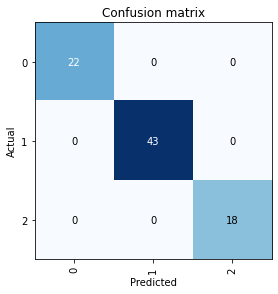

In [ ]:
# save model and see the performancec in validaiton.
path = 'model_efficient1.pkl'
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
learn.export(path) #将模型存入